<a href="https://colab.research.google.com/github/PM461/NLP/blob/main/pseudoword_ambiguity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pseudoword Ambiguity Reduction Analysis
This notebook processes multilingual pseudowords using BabelNet, computes ambiguity reduction scores, and visualizes the results.

In [75]:
!pip install -r requirements.txt

  Using cached aiogram-3.20.0-py3-none-any.whl.metadata (7.6 kB)
  Using cached aiohttp-3.12.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached argcomplete-3.5.3-py3-none-any.whl.metadata (16 kB)
  Using cached attrs-24.1.0-py3-none-any.whl.metadata (14 kB)
  Using cached autocommand-2.2.2-py3-none-any.whl.metadata (15 kB)
  Using cached beautifulsoup4-4.13.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached btrfsutil-6.14.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached clingo-5.7.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.0 kB)
  Using cached cryptography-45.0.3-cp311-abi3-manylinux_2_34_x86_64.whl.metadata (5.7 kB)
ERROR: Could not find a version that satisfies the requirement cupshelpers==1.0 (from

Importazione delle librerie necessarie all'esecuzione

In [84]:
import os
import csv
import json
import logging
import requests
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv, find_dotenv
from typing import List, Dict, Optional, Tuple, Any, Set
from functools import partial
from google.colab import userdata

**Questa sezione è utile per la gestione delle API di babelNet.**

Istruzioni d'uso: se eseguite il codice su code colab andare su 'secret' (l'icona della chiave a sinistra) e mettere le seguenti variabili d'ambiente:

BABELNET_API_KEY= La_tua_chiave_personale_babelnet

WORD_PAIRS=word_pairs.csv (il file da dove prendere le parole)

LANGUAGES=EN,IT,ES,FR (le lingue che si vogliono mappare)

In [85]:


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)
    logging.info(f"Loaded .env from {dotenv_path}")
else:
    logging.warning("No .env file found.")

API_KEY = userdata.get("BABELNET_API_KEY")
INPUT_FILE = userdata.get("WORD_PAIRS")
LANGS = [lang.strip().upper() for lang in userdata.get("LANGUAGES").split(',') if lang.strip()]


**load_word_tuples**:
Legge un file CSV riga per riga.

Pulisce ogni parola rimuovendo gli spazi vuoti.

Scarta righe con meno di 2 parole significative.

In [86]:
def load_word_tuples(filepath: str) -> List[Tuple[str, ...]]:
    with open(filepath, newline='', encoding='utf-8') as f:
        return [tuple(word.strip() for word in row if word.strip())
                for row in csv.reader(f) if len(row) >= 2]

**get_sense:** interroga BabelNet per ottenere i possibili significati (sensi) di una parola in diverse lingue.

In [87]:
def get_sense(
    lemma: str,
    targetLang: List[str],
    key: str,
    source: str = "WIKI"
) -> Optional[List[Dict[str, Any]]]:
    url = 'https://babelnet.io/v9/getSenses'
    searchLang = targetLang[0]
    params = {
        'lemma': lemma,
        'searchLang': searchLang,
        'targetLang': targetLang,
        'key': key,
        'source': source
    }

    response = requests.get(url, params=params, timeout=10)
    try:
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        logging.error(f"Error fetching synsets: {e}")
        return None

**find_synset_language_dict**:

Prende in input una lista di dizionari synsets e costruisce un dizionario che mappa ogni lingua a un insieme di ID di synset

In [88]:

def find_synset_language_dict(synsets: List[dict]) -> Dict[str, Set[str]]:
    lang_synsets: Dict[str, Set[str]] = {}
    for synset in synsets:
        props = synset.get('properties', {})
        synset_id = props.get('synsetID', {}).get('id')
        lang = props.get('language', '').upper()
        if synset_id and lang:
            lang_synsets.setdefault(lang, set()).add(synset_id)
    return lang_synsets


**extract_lemma_for_lang**

Dato un elenco di synset, un synset_id e una lingua (lang), la funzione cerca e restituisce il lemma (la forma base della parola) corrispondente a quel synset e lingua.

In [89]:
def extract_lemma_for_lang(synsets: List[Dict[str, Any]], synset_id: str, lang: str) -> str:
   for synset in synsets:
        props = synset.get('properties', {})
        sid = props.get('synsetID', {}).get('id')
        language = props.get('language', '').upper()
        if sid == synset_id and language == lang.upper():
            return props.get('fullLemma') or props.get('simpleLemma') or "N/A"
   return "N/A"

**save_pseudoword_csv**

Salva su file CSV strutturato le informazioni di una "pseudoword" formato da più parole in diverse lingue, synset comuni e relativi lemmi

In [90]:
def save_pseudoword_csv(words: Tuple[str, ...], synsets: List[Dict[str, Any]], common_synsets: Set[str], langs: List[str]):
    pseudoword = '-'.join(words)
    os.makedirs('rsrc', exist_ok=True)
    path = f"rsrc/pseudowords_{pseudoword}.csv"
    with open(path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["pseudoword"] + [f"{lang}_word" for lang in langs] + [f"{lang}_sense" for lang in langs] + ["common_synset_id"])
        for sid in common_synsets:
            row = [pseudoword]
            for i, lang in enumerate(langs):
                row.append(words[i])
            for lang in langs:
                row.append(extract_lemma_for_lang(synsets, sid, lang))
            row.append(sid)
            writer.writerow(row)

def save_pseudoword(
    words: Tuple[str, ...],
    pseudoword: str,
    synsets: List[Dict[str, Any]],
    common_synsets: Set[str],
    langs: List[str]
) -> None:
    save_pseudoword_csv(words, synsets, common_synsets, langs)

def save_pseudoword_multi(
    pseudoword: str,
    words: Tuple[str, ...],
    synsets: List[Dict[str, Any]],
    common_synsets: Set[str],
    langs: List[str]
) -> None:
    save_pseudoword(words, pseudoword, synsets, common_synsets, langs)

**process_word_tuple**

Calcola la riduzione di ambiguità per un gruppo di parole (words) in diverse lingue (langs), salva i dati relativi ai synset comuni e restituisce un dizionario con il punteggio.

In [91]:

def process_word_tuple(words: Tuple[str, ...], langs: List[str], api_key: str) -> Optional[dict]:
    synsets = get_sense(words[0], langs, api_key)
    if not synsets:
        return None
    lang_synsets = find_synset_language_dict(synsets)
    synset_sets = [lang_synsets.get(lang, set()) for lang in langs]
    if not all(synset_sets):
        return None
    common = set.intersection(*synset_sets)

    Sx = len(synset_sets[0])
    Sy = len(synset_sets[1])
    Sxy = len(common)
    total = Sx + Sy
    reduction = (total - 2 * Sxy) / total if total else 0.0

    save_pseudoword_csv(words, synsets, common, langs)
    return {
        "pseudoword": '-'.join(words),
        "Sx": Sx,
        "Sy": Sy,
        "Sxy": Sxy,
        "ambiguity_reduction": round(reduction, 3)
    }



**Gestione del flusso**

gestisce il flusso completo: carica dati, calcola riduzione di ambiguità in parallelo, salva i dati e produce un grafico per visualizzare i risultati.

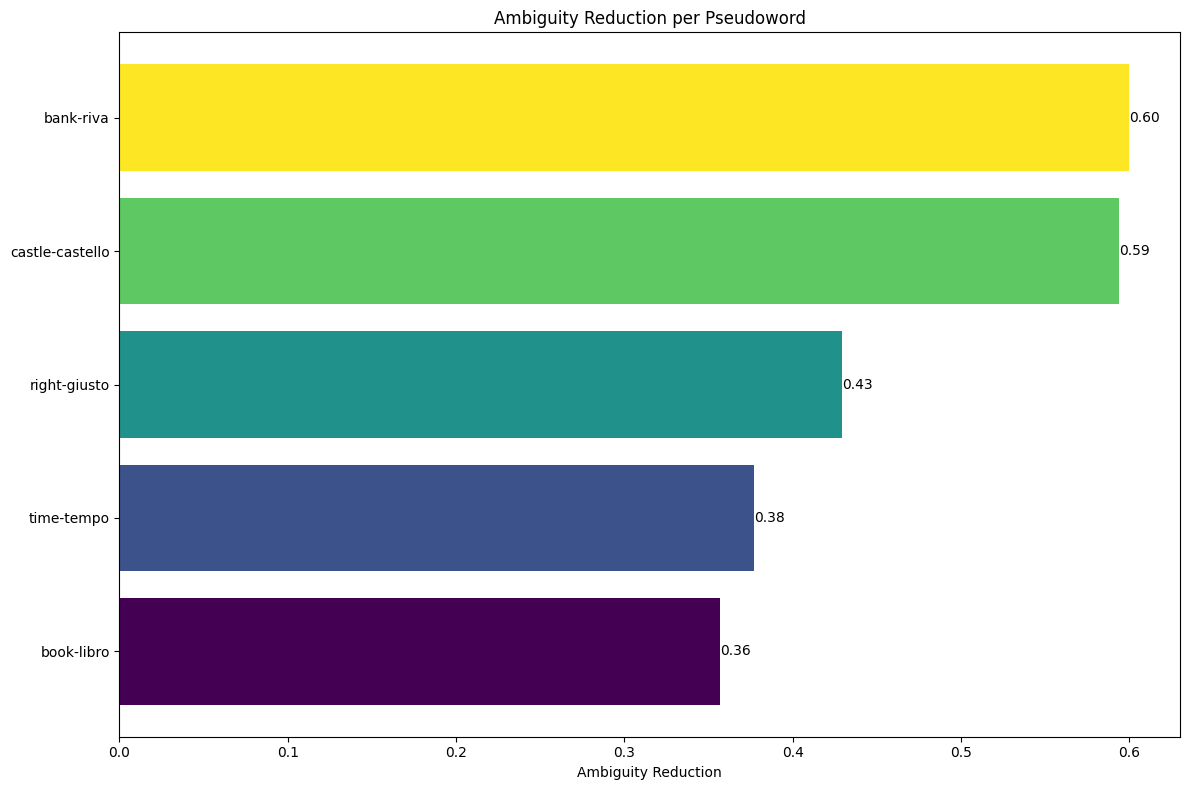

,pseudoword,Sx,Sy,Sxy,ambiguity_reduction
0,right-giusto,9,5,4,0.429
1,bank-riva,20,5,5,0.600
2,castle-castello,46,23,14,0.594
3,time-tempo,125,58,57,0.377
4,book-libro,18,10,9,0.357


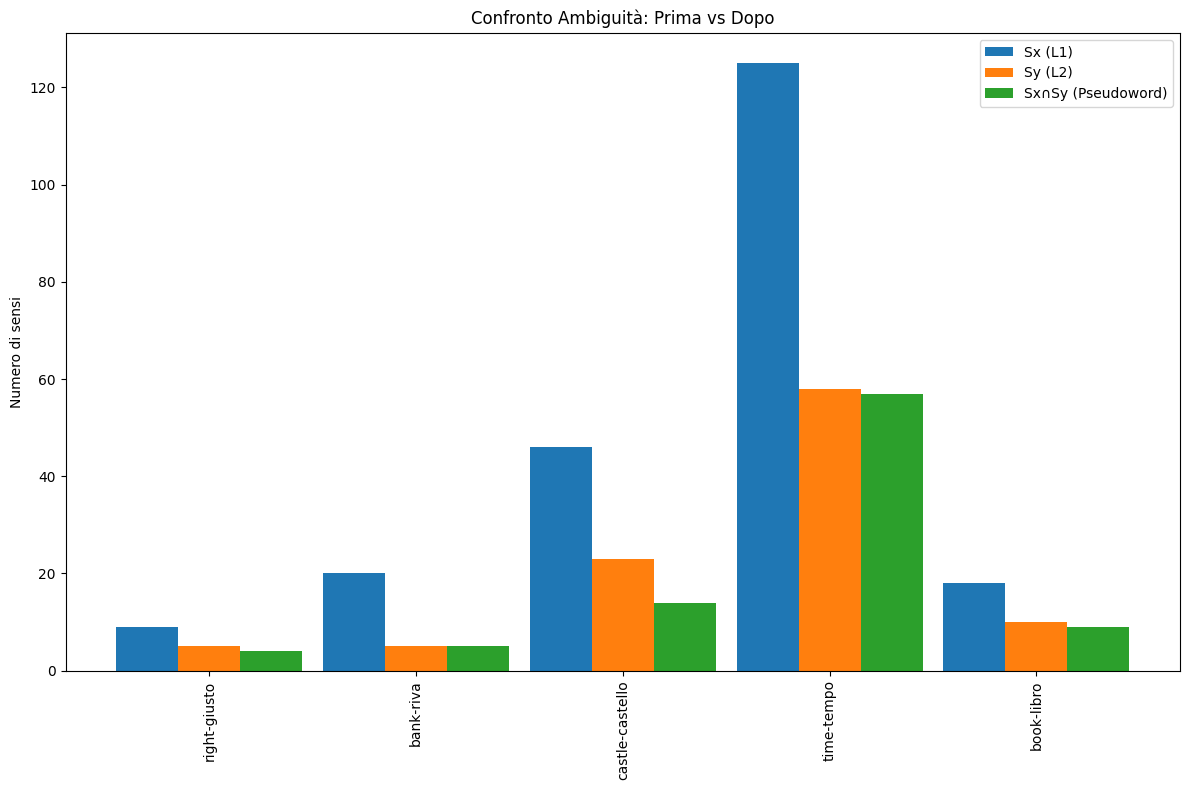

In [93]:
word_tuples = load_word_tuples(INPUT_FILE)
valid_tuples = [wt for wt in word_tuples if len(wt) == len(LANGS)]
results = []

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    func = partial(process_word_tuple, langs=LANGS, api_key=API_KEY)
    futures = {executor.submit(func, wt): wt for wt in valid_tuples}
    for future in concurrent.futures.as_completed(futures):
        res = future.result()
        if res:
            results.append(res)

os.makedirs('rsrc', exist_ok=True)
with open('rsrc/ambiguity_scores.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

if results:
    sorted_data = sorted(results, key=lambda x: x['ambiguity_reduction'])
    pseudowords = [d['pseudoword'] for d in sorted_data]
    scores = [d['ambiguity_reduction'] for d in sorted_data]

    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(pseudowords))
    plt.barh(y_pos, scores, color=plt.cm.viridis(np.linspace(0, 1, len(pseudowords))))
    plt.yticks(y_pos, pseudowords)
    plt.xlabel('Ambiguity Reduction')
    plt.title('Ambiguity Reduction per Pseudoword')
    for i, score in enumerate(scores):
        plt.text(score, i, f'{score:.2f}', va='center', ha='left')
    plt.tight_layout()
    plt.savefig('ambiguity_reduction_plot.png')
    plt.show()
else:
    logging.warning("No results to plot.")

import pandas as pd

df = pd.DataFrame(results)
display(df.head())

plt.figure(figsize=(12, 8))
indices = np.arange(len(results))
width = 0.3

Sx_vals = [r["Sx"] for r in results]
Sy_vals = [r["Sy"] for r in results]
Sxy_vals = [r["Sxy"] for r in results]

plt.bar(indices - width, Sx_vals, width=width, label='Sx (L1)')
plt.bar(indices, Sy_vals, width=width, label='Sy (L2)')
plt.bar(indices + width, Sxy_vals, width=width, label='Sx∩Sy (Pseudoword)')

plt.xticks(indices, [r["pseudoword"] for r in results], rotation=90)
plt.ylabel("Numero di sensi")
plt.title("Confronto Ambiguità: Prima vs Dopo")
plt.legend()
plt.tight_layout()
plt.savefig('ambiguity_comparison_plot.png')
plt.show()

